In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf
# tf.keras.backend.set_floatx('float64')

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [3]:
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt

def graph_dof(edge_list, node_list):
    dof = len(edge_list)/len(node_list)
    return dof
def gen_graph(M):
    G = nx.DiGraph()
    edge_list = []
    k = 0
    i = 0
    for k in range(M):
        for i in range(M):
            edge_list.append((i,k))
        
    node_list = range(M)
    G.add_nodes_from(node_list)
    G.add_edges_from(edge_list)
    return G, edge_list, node_list

options = {
    'node_color': '#0a708c',
    'width': 1.5,
    'edge_color': '#555555',
    'font_color': '#ffffff',
    'node_size': 500,
}

# Case 1

10.0

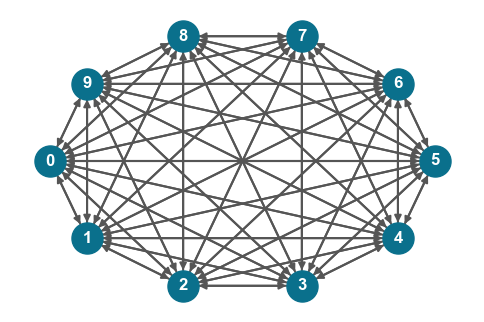

In [4]:
graph, edge_list, node_list = gen_graph(10)
fig, ax = plt.subplots(dpi=100)

nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)

graph_dof(graph.edges(), node_list)

Reference Model

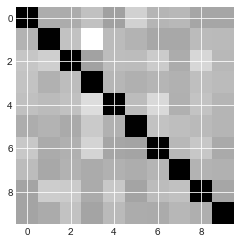

In [5]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
# mobility_matrix[1,:]= 0
# mobility_matrix[:,1]= 0
mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(mobility_matrix, mobility_matrix_diag)
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(mobility_matrix))
# np.diagonal(mobility_matrix)
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


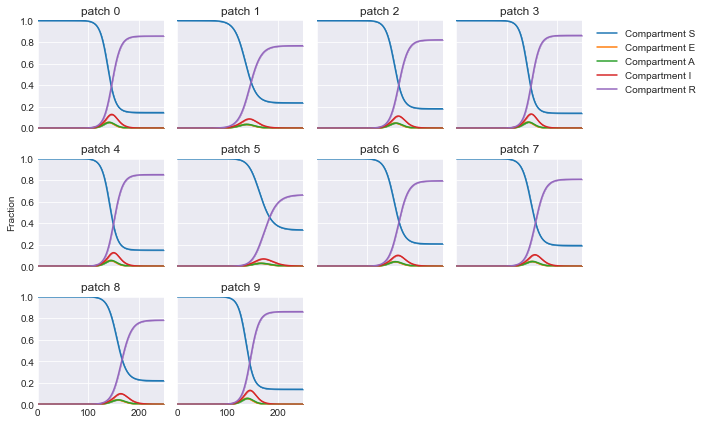

In [7]:
def gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, mobility_matrix=mobility_matrix, population=None, area= None):
    tmat = maxentep.TransitionMatrix(compartments, [1,2])
#     eta = 1/2
#     alpha = 1/2
#     mu = 1/5
    tmat.add_transition('E', 'A', 1/eta, 0)
    tmat.add_transition('A', 'I', 1/alpha, 0)
    tmat.add_transition('I', 'R', 1/mu, 0)
    infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
#     timesteps = 250
    model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node 1
    initial_exposed = 1/population[1]
    start[1,0] = initial_exposed
    # start[0,0] = 0.05
#     beta = 0.03
    mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj
ref_traj = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population, area=area, mobility_matrix=mobility_matrix)
patch_quantile(ref_traj, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Add Restraints

Restraints are set in this time range: [0, 180]
122 0.015657691 0.0334527774824479
73 3.4974753e-05 0.0
45 8.8457443e-07 0.007945232507143487
108 0.0028866034 0.01442355736609968
3 1.1672253e-11 0.0
115 0.0103614405 0.048952081556095116
66 2.0206047e-05 0.01900862218585365
24 4.1891177e-08 0.0017510667188805676
17 1.0552815e-08 0.0
38 2.9669027e-07 0.01716505239736926
171 0.030818883 0.03270556912915374
45 7.988033e-07 0.0
101 0.0019340848 0.0011484284439040055
129 0.06601216 0.04265028903508236
66 1.909915e-05 0.010484632361084694
17 8.088455e-09 0.0
122 0.0048208325 0.058085383813693145
157 0.10557671 0.11378249826150724
31 6.046642e-08 0.009713098335787616
17 6.7200525e-09 0.02623053766147473
59 3.5139087e-06 0.0
3 6.451803e-12 0.0
171 0.58774334 0.5720416112944946
136 0.03894579 0.006839909049684845
3 1.8099601e-10 0.0
129 0.0497725 0.0580935019170498
52 3.4130644e-06 0.0
38 5.0210974e-07 0.015624464143942097
108 0.0067300834 0.026914973994460332
143 0.32328814 0.3375559340915126
8

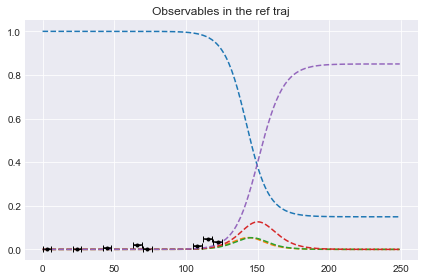

In [10]:
npoints = 4
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
def gen_restraints(ref_traj):
    prior = maxentep.EmptyPrior()

    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.02, start_time=0, end_time=180)
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observables in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches
restraints, plot_fxns_list, restrained_patches = gen_restraints(ref_traj)

# Sample

In [15]:
def gen_samples(mobility_matrix, timesteps =250, area = area, populations = population, sparse=False):
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 1, 1)
    tmat.add_transition('A', 'I', 3, 1)
    tmat.add_transition('I', 'R', 7, 2)
    hyper_pram = maxentep.ParameterHypers()
    hyper_pram.beta_low = 0.005
    hyper_pram.beta_high = 0.05
    hyper_pram.beta_var = 0.03
    hyper_pram.start_high = 5e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 4e-6
    start_logits = np.zeros((M))
    param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram)
    import tqdm
    N = 256
    batches = 16
    total_batches = N * batches
    outs = []
    infect = maxentep.contact_infection_func(infections_compartments, area = area)
    model = maxentep.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        if sparse:
            # This updates the sampled R_dist based on the sparse mobility network (make sure sparse=True when calling)
            R_dist = ps[0]
            sparse_R_dist_list = []
            for i in range(R_dist.shape[0]):
                sparse_R_dist = R_dist[i].numpy().flatten()
                sparse_R_dist[np.where(mobility_matrix.flatten()==0)] = 0
                sparse_R_dist_list.append(sparse_R_dist.reshape(M,M))
            #     print(sparse_R_dist)
            ps[0] = tf.stack(sparse_R_dist_list)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    param_batch = prior_prams[0]
    mask = tf.greater(param_batch[2], 0)
    start_exposed_dist = tf.boolean_mask(param_batch[2], mask).numpy()
    # prior_param_dist = maxentep.get_dist(prior_prams)
    # maxentep.plot_dist(*prior_param_dist)
    return trajs
trajs = gen_samples(mobility_matrix, timesteps =250, area = area, populations = population)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.40s/it]


(array([   7,   33,   39,   42,   51,   58,   64,   71,   78,   83,   95,
        117,  134,  135,  140,  156,  158,  184,  190,  197,  201,  232,
        244,  247,  250,  254,  255,  259,  260,  266,  268,  279,  283,
        300,  308,  313,  323,  325,  332,  344,  349,  350,  351,  357,
        363,  366,  372,  373,  374,  389,  408,  421,  428,  437,  461,
        464,  466,  469,  473,  478,  495,  502,  506,  514,  520,  523,
        527,  532,  533,  545,  549,  556,  588,  599,  604,  606,  607,
        613,  623,  650,  666,  678,  685,  688,  722,  738,  748,  768,
        774,  775,  801,  802,  808,  809,  811,  816,  818,  824,  856,
        866,  876,  899,  903,  918,  920,  924,  929,  933,  936,  937,
        941,  954,  958,  971,  979,  996, 1014, 1023, 1033, 1039, 1047,
       1048, 1056, 1063, 1065, 1077, 1079, 1083, 1100, 1107, 1119, 1122,
       1126, 1136, 1138, 1143, 1148, 1151, 1154, 1159, 1164, 1194, 1203,
       1212, 1231, 1232, 1241, 1246, 1252, 1255, 1

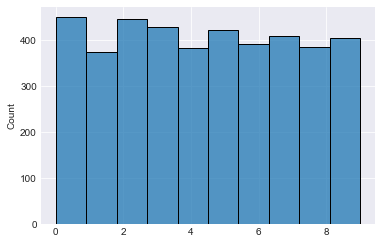

In [16]:
prior_exposed_patch = maxentep.exposed_finder(trajs)
print(np.where(prior_exposed_patch==0))
sns.histplot(x=prior_exposed_patch, label='Prior',
            color='C0',bins=M)

In [17]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
#     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()

Plotting 10 patches in a 3 x 4 grid


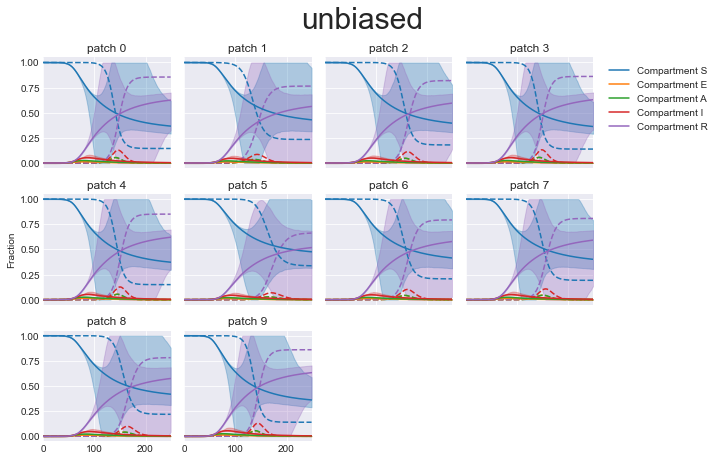

In [18]:
compare_to_ref(ref_traj,trajs, weights=None, method='unbiased', patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

# Applying MaxEnt

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0153 - weight-entropy: 6.9285
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0101 - weight-entropy: 6.9070
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0073 - weight-entropy: 6.8704
Epoch 4/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0059 - weight-entropy: 6.8307
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0054 - weight-entropy: 6.7952
Epoch 6/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0052 - weight-entropy: 6.7675
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0052 - weight-entropy: 6.7473
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0051 - weight-entropy: 6.7343
Epoch 9/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0051 - weight-entropy: 6.7270
Epoch 10/500
4/4 [==============================] - 0s 1ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 6.5176
Epoch 80/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 6.5133
Epoch 81/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 6.5083
Epoch 82/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 6.5039
Epoch 83/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 6.5005
Epoch 84/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 6.4971
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 6.4911
Epoch 86/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 6.4870
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 6.4831
Epoch 88/500
4/4 [==============================] - 0s 1ms/step - loss: 0.002

4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 6.1887
Epoch 157/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 6.1826
Epoch 158/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 6.1781
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 6.1739
Epoch 160/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 6.1698
Epoch 161/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 6.1682
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 6.1608
Epoch 163/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 6.1562
Epoch 164/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 6.1535
Epoch 165/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 5.8166
Epoch 235/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.8100
Epoch 236/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.8099
Epoch 237/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.8032
Epoch 238/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.7936
Epoch 239/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.7920
Epoch 240/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 5.7843
Epoch 241/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.7804
Epoch 242/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 5.7733
Epoch 243/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 5.4462
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 5.4453
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 5.4314
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 5.4160
Epoch 316/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 5.4166
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 5.4103
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 5.4189
Epoch 319/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 5.4062
Epoch 320/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 5.3992
Epoch 321/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 5.1044
Epoch 389/500
4/4 [==============================] - 0s 2ms/step - loss: 9.5205e-04 - weight-entropy: 5.1559
Epoch 390/500
4/4 [==============================] - 0s 1ms/step - loss: 8.9217e-04 - weight-entropy: 5.1093
Epoch 391/500
4/4 [==============================] - 0s 2ms/step - loss: 9.2900e-04 - weight-entropy: 5.1114
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 8.8495e-04 - weight-entropy: 5.0822
Epoch 393/500
4/4 [==============================] - 0s 2ms/step - loss: 9.0759e-04 - weight-entropy: 5.0891
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 8.5665e-04 - weight-entropy: 5.0772
Epoch 395/500
4/4 [==============================] - 0s 2ms/step - loss: 9.4524e-04 - weight-entropy: 5.1142
Epoch 396/500
4/4 [==============================] - 0s 1ms/step - loss: 9.3341e-04 - weight-entropy: 5.0898
Epoch 397/500
4/4 [==================

4/4 [==============================] - 0s 2ms/step - loss: 9.0445e-04 - weight-entropy: 4.8979
Epoch 463/500
4/4 [==============================] - 0s 2ms/step - loss: 7.4212e-04 - weight-entropy: 4.8594
Epoch 464/500
4/4 [==============================] - 0s 1ms/step - loss: 8.3265e-04 - weight-entropy: 4.8902
Epoch 465/500
4/4 [==============================] - 0s 2ms/step - loss: 7.9331e-04 - weight-entropy: 4.8742
Epoch 466/500
4/4 [==============================] - 0s 1ms/step - loss: 6.9892e-04 - weight-entropy: 4.8526
Epoch 467/500
4/4 [==============================] - 0s 1ms/step - loss: 6.6885e-04 - weight-entropy: 4.8131
Epoch 468/500
4/4 [==============================] - 0s 1ms/step - loss: 7.3652e-04 - weight-entropy: 4.8535
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 7.3197e-04 - weight-entropy: 4.8870
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 7.4228e-04 - weight-entropy: 4.8328
Epoch 471/500
4/4 [==============

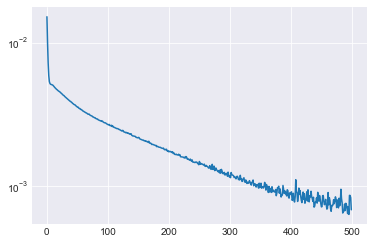

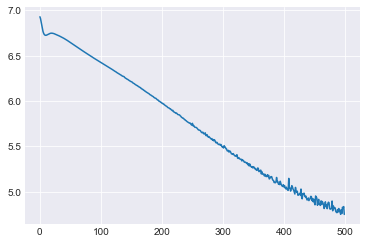

In [19]:
def maxent_fit(trajs,restraints):
    me_model = maxentep.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=1024,epochs=500)
    plt.plot(me_history.history['loss'])
    plt.yscale('log')
    plt.show()
    plt.plot(me_history.history['weight-entropy'])
    return me_model
me_model = maxent_fit(trajs, restraints)

In [22]:
def compare_patches(ref_traj, trajs,weights_dict, method ,*args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()


Plotting 10 patches in a 3 x 4 grid


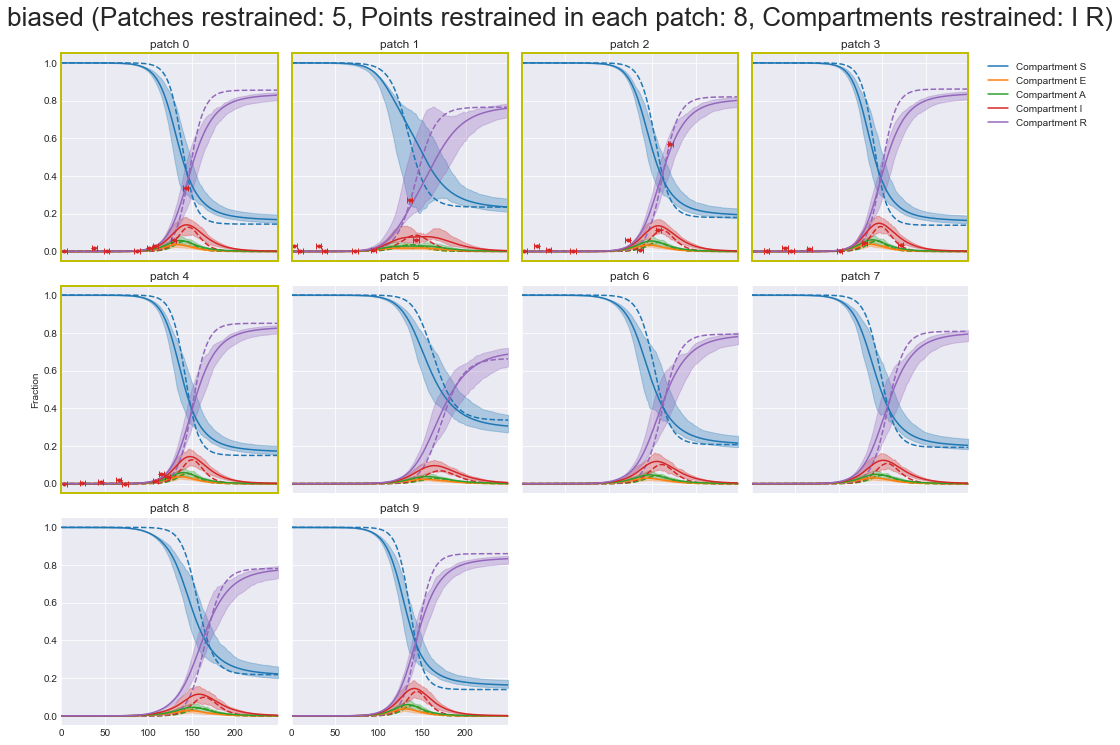

In [23]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights}
compare_patches(ref_traj, trajs, weights_dict,'biased', patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

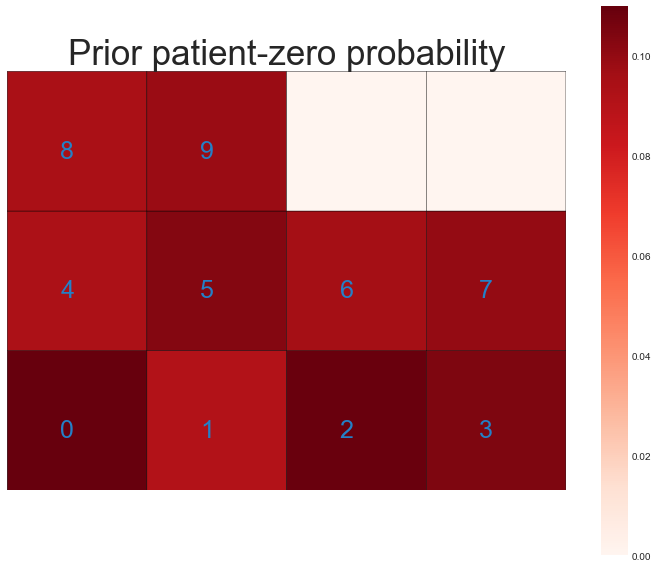

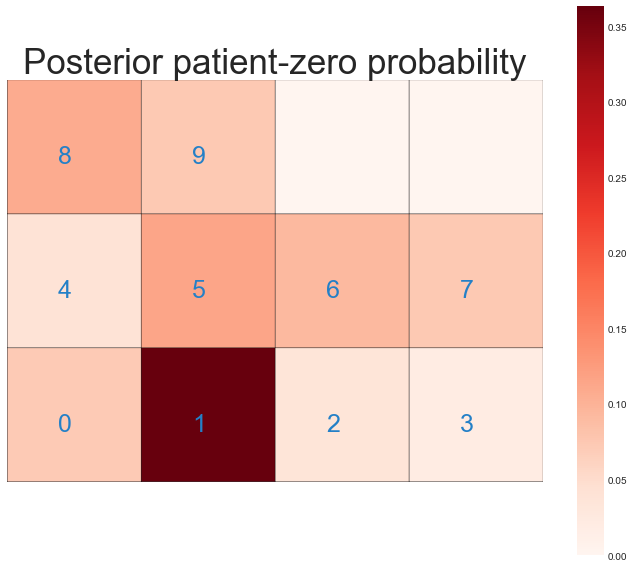

In [24]:
prior_exposed_patch = maxentep.exposed_finder(trajs)
me_w = me_model.traj_weights
maxentep.p0_map(prior_exposed_patch, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

In [25]:
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print('Top 5 posterior probabilities for P0: \n', sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.36310622920701746, 'patch 1'), (0.1159600281804737, 'patch 5'), (0.10826275312988018, 'patch 8'), (0.0934083774518123, 'patch 6'), (0.0751728470982208, 'patch 7')]


 # Case 2

6.9

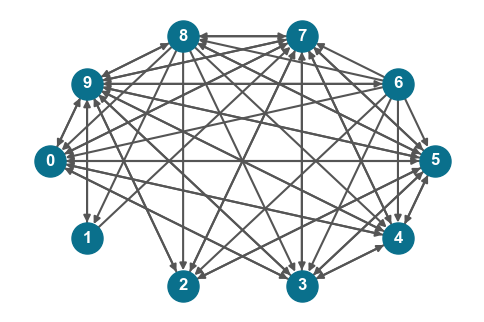

In [67]:
graph, edge_list, node_list = gen_graph(10)
fig, ax = plt.subplots(dpi=100)
graph.remove_edges_from([(1, i) for i in range(0,7) if i!=1])
graph.remove_edges_from([(i, 1) for i in range(0,8)  if i!=1])
graph.remove_edges_from([(2, i) for i in range(0,5) if i!=2])
graph.remove_edges_from([(i,2) for i in range(0,5)  if i!=2])
graph.remove_edges_from([(i,8) for i in range(0,5)  if i!=8])
graph.remove_edges_from([(i,6) for i in range(0,9)  if i!=6])
nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)
graph_dof(graph.edges(), node_list)

In [68]:
def sparse_graph_mobility(sparse_graph, fully_connected_mobility_matrix):
    R'''
    Generates a sprase mobility matrix based on a sparse graph and a fully connected mobility matrix inputs
    '''
    sparse_mobility_matrix = np.zeros_like(fully_connected_mobility_matrix)
    for i, edge in enumerate(sparse_graph.edges()):
        sparse_mobility_matrix[edge[0], edge[1]] = fully_connected_mobility_matrix[edge[0], edge[1]]
    return sparse_mobility_matrix


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


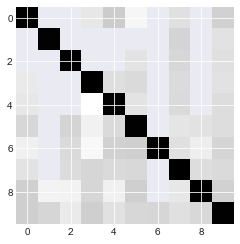

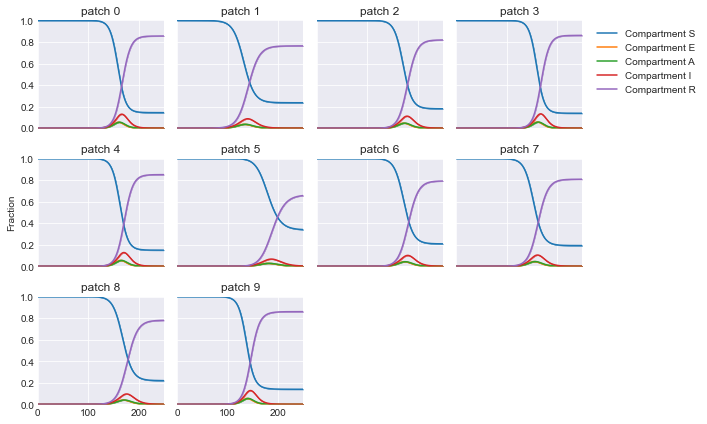

In [69]:
sparse_mobility_matrix = sparse_graph_mobility(graph, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix))
sparse_ref_traj = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250,
                               population=population, area=area, mobility_matrix=sparse_mobility_matrix)
patch_quantile(sparse_ref_traj, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [0, 180]
108 0.017018199 0.023662897427434895
87 0.0025734587 0.03817408716730747
150 0.0698467 0.08721899525211681
59 0.00018523987 0.0
59 0.00037229227 0.01944493857519779
157 0.6254365 0.6404894861853402
87 0.0052341553 0.003085862713780992
122 0.11970142 0.09403819366419952
129 0.0012505464 0.014841903740882628
10 1.6813871e-11 0.0
164 0.03165176 0.019718344272052026
17 1.4924166e-10 0.011341164399645309
66 5.848081e-07 0.004071551868574497
38 8.563636e-09 0.0
80 3.8491457e-06 0.015377012064156046
115 0.00034222295 0.03052707995069828
24 4.7419235e-10 0.006655964822281447
87 6.848942e-06 0.02028185989208621
45 1.7891855e-08 0.010133398412422879
3 3.415332e-13 0.0
24 3.711109e-10 0.020280178453360376
164 0.11696669 0.1268804347979688
94 2.422761e-05 0.02394768302980793
171 0.21017425 0.22494949297106334
122 0.0006134966 0.0
87 6.5001154e-06 0.0
150 0.017078485 0.024640367834025498
129 0.0014746825 0.0
136 0.0052655563 0.0013275137779524228
52 5

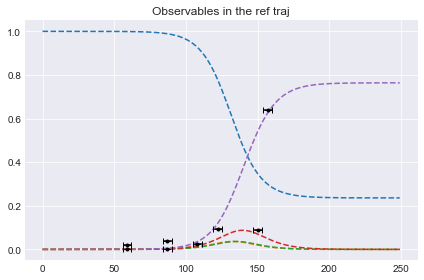

In [76]:
restraints, plot_fxns_list, restrained_patches = gen_restraints(sparse_ref_traj)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.40s/it]


Plotting 10 patches in a 3 x 4 grid


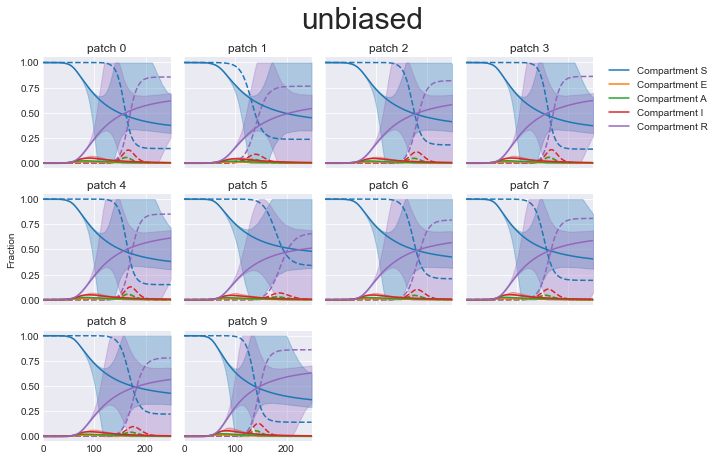

In [77]:
sparse_trajs = gen_samples(sparse_mobility_matrix, timesteps =250, area = area, populations = population, sparse=True)
compare_to_ref(sparse_ref_traj, sparse_trajs, weights=None, method='unbiased', patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0143 - weight-entropy: 6.9288
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0107 - weight-entropy: 6.9100
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0086 - weight-entropy: 6.8784
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0076 - weight-entropy: 6.8434
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0072 - weight-entropy: 6.8111
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0071 - weight-entropy: 6.7854
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0070 - weight-entropy: 6.7663
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0071 - weight-entropy: 6.7532
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0071 - weight-entropy: 6.7451
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 0.0067 - weight-entropy: 6.7363
Epoch 80/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0067 - weight-entropy: 6.7352
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0067 - weight-entropy: 6.7344
Epoch 82/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0067 - weight-entropy: 6.7336
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0067 - weight-entropy: 6.7328
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0066 - weight-entropy: 6.7317
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0066 - weight-entropy: 6.7310
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0066 - weight-entropy: 6.7303
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0066 - weight-entropy: 6.7292
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.006

4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - weight-entropy: 6.3361
Epoch 158/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0049 - weight-entropy: 6.3312
Epoch 159/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0049 - weight-entropy: 6.3201
Epoch 160/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 6.2961
Epoch 161/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0048 - weight-entropy: 6.2919
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 6.2769
Epoch 163/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0046 - weight-entropy: 6.2664
Epoch 164/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0046 - weight-entropy: 6.2561
Epoch 165/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0046 - weight-entropy: 6.2416
Epoch 166/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 5.6274
Epoch 235/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 5.6389
Epoch 236/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 5.6087
Epoch 237/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 5.6139
Epoch 238/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 5.6524
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 5.6045
Epoch 240/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 5.5920
Epoch 241/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 5.5750
Epoch 242/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 5.5840
Epoch 243/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 5.0384
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.9907
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.9863
Epoch 315/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 5.0086
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.9719
Epoch 317/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.9884
Epoch 318/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 4.9444
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.9368
Epoch 320/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.9890
Epoch 321/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.4310
Epoch 391/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.4219
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.4278
Epoch 393/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 4.4681
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.4094
Epoch 395/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.4093
Epoch 396/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.4213
Epoch 397/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 4.4549
Epoch 398/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.4206
Epoch 399/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.0871
Epoch 468/500
4/4 [==============================] - 0s 2ms/step - loss: 9.8165e-04 - weight-entropy: 4.0974
Epoch 469/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.2042
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1381
Epoch 471/500
4/4 [==============================] - 0s 2ms/step - loss: 9.7788e-04 - weight-entropy: 4.0762
Epoch 472/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0522
Epoch 473/500
4/4 [==============================] - 0s 2ms/step - loss: 9.1799e-04 - weight-entropy: 4.0260
Epoch 474/500
4/4 [==============================] - 0s 2ms/step - loss: 9.7201e-04 - weight-entropy: 4.0314
Epoch 475/500
4/4 [==============================] - 0s 2ms/step - loss: 9.3957e-04 - weight-entropy: 4.0002
Epoch 476/500
4/4 [==============================

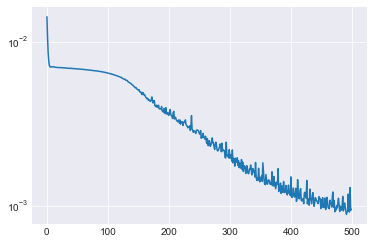

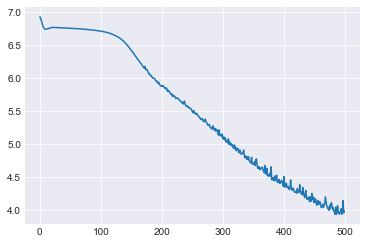

In [78]:
sparse_me_model = maxent_fit(sparse_trajs, restraints)

Plotting 10 patches in a 3 x 4 grid


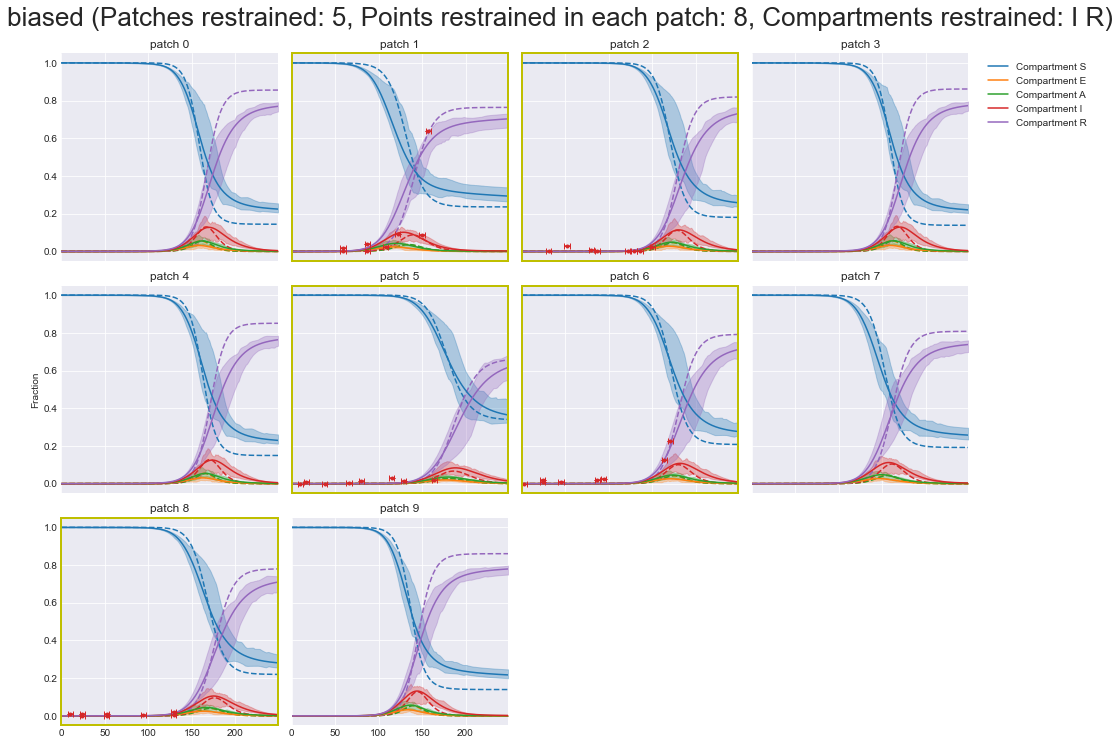

In [79]:
weights_dict = {'unbiased':None, 'biased':sparse_me_model.traj_weights}
compare_patches(sparse_ref_traj, sparse_trajs, weights_dict,'biased', patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

Top 5 posterior probabilities for P0: 
 [(0.8019069821566, 'patch 1'), (0.028972964274319023, 'patch 7'), (0.02390064042325439, 'patch 3'), (0.022987003620084552, 'patch 0'), (0.022869809706909678, 'patch 5')]


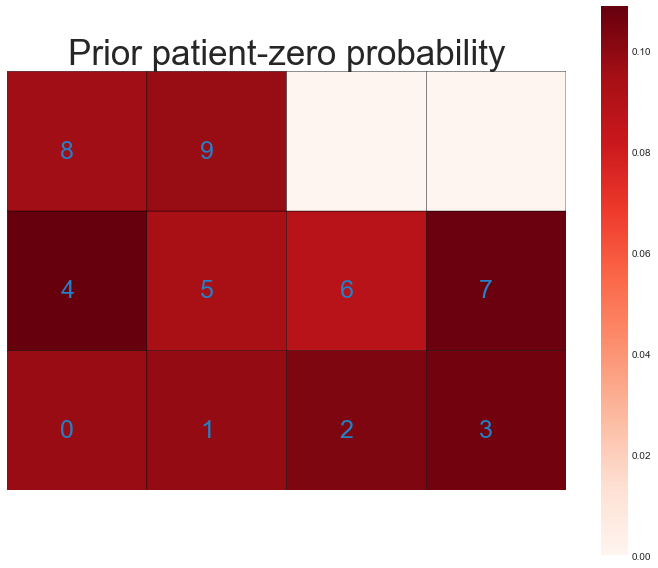

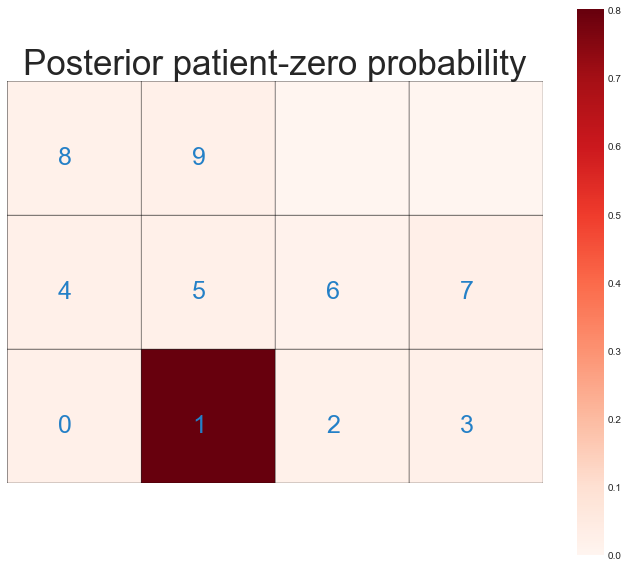

In [81]:
prior_exposed_patch = maxentep.exposed_finder(sparse_trajs)
maxentep.p0_map(prior_exposed_patch, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch, M, weights = sparse_me_model.traj_weights, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = sparse_me_model.traj_weights)
print('Top 5 posterior probabilities for P0: \n', sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5])

# Case 3

4.5

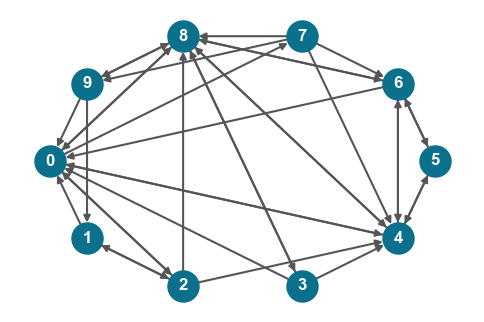

In [44]:
graph, edge_list, node_list = gen_graph(10)
fig, ax = plt.subplots(dpi=100)
graph.remove_edges_from([(1, i) for i in range(3,9)])
graph.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i != 1])
graph.remove_edges_from([(i, 2) for i in range(3,9) ])
graph.remove_edges_from([(i, 6) for i in range(0,4)])
graph.remove_edges_from([(i, 7) for i in range(1,10) if i != 7])
graph.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5])
graph.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph.remove_edges_from([(9,i) for i in range(2,8)])
graph.remove_edges_from([(i,9) for i in range(0,7)])
# graph.remove_edges_from([(i,4) for i in range(0,7)])
nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)
graph_dof(graph.edges(), node_list)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


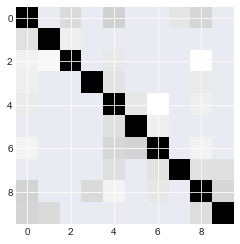

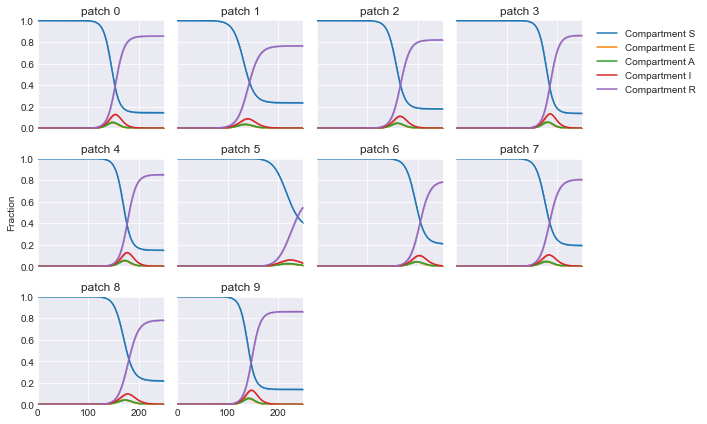

In [45]:
sparse_mobility_matrix = sparse_graph_mobility(graph, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix))
sparse_ref_traj = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population, area=area, mobility_matrix=sparse_mobility_matrix)
patch_quantile(sparse_ref_traj, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [0, 180]
24 6.8141867e-06 0.0
136 0.084948264 0.08201016287177444
52 9.628901e-05 0.008718554562013455
164 0.030852336 0.04523694300322051
129 0.20239803 0.20136373106438407
108 0.03679782 0.05158463781590299
171 0.71897274 0.7205176463270418
66 0.0007276442 0.0
157 0.03839434 0.06624470837133392
17 8.682457e-11 0.02075171342783725
66 4.1571306e-07 0.0003762515485455759
24 4.4044615e-10 0.0
10 2.9323761e-12 0.0
59 1.8560856e-07 0.0017192250772437739
157 0.0735315 0.08857043274870306
164 0.14150456 0.1527643503123506
94 0.0001464166 0.0
101 0.00033116218 0.0
157 0.09304744 0.0607602110845904
108 0.00074503187 0.0
87 0.00010181096 0.01977169975864361
108 0.001206887 0.047246233127218165
164 0.3743302 0.3851772200377504
52 1.3459018e-06 0.0
122 0.00047433728 0.01192709825546445
136 0.0030441242 0.005852642414172214
45 6.9821433e-09 0.0
52 2.1556712e-08 0.0
24 1.0686322e-10 0.0
122 0.000651928 0.011472092413318103
66 2.2197644e-07 0.0
59 7.467968e-08 

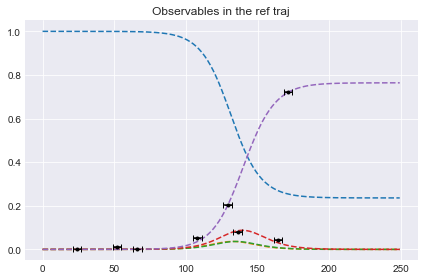

In [46]:
restraints, plot_fxns_list, restrained_patches = gen_restraints(sparse_ref_traj)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.34s/it]


Plotting 10 patches in a 3 x 4 grid


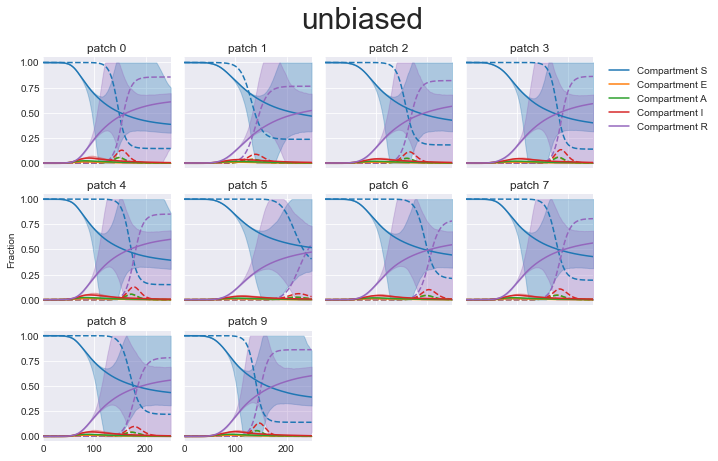

In [47]:
sparse_trajs = gen_samples(sparse_mobility_matrix, timesteps =250, area = area, populations = population, sparse=True)
compare_to_ref(sparse_ref_traj, sparse_trajs, weights=None, method='unbiased', patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0173 - weight-entropy: 6.9283
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0135 - weight-entropy: 6.9063
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0116 - weight-entropy: 6.8700
Epoch 4/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 6.8323
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0109 - weight-entropy: 6.8010
Epoch 6/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 6.7787
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 6.7658
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 6.7606
Epoch 9/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 6.7614
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 2ms/step - loss: 0.0074 - weight-entropy: 6.5750
Epoch 80/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0073 - weight-entropy: 6.5572
Epoch 81/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0071 - weight-entropy: 6.5383
Epoch 82/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0071 - weight-entropy: 6.5233
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0068 - weight-entropy: 6.4969
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0068 - weight-entropy: 6.4771
Epoch 85/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0066 - weight-entropy: 6.4523
Epoch 86/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0065 - weight-entropy: 6.4280
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0064 - weight-entropy: 6.4054
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.006

4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.9564
Epoch 158/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 5.0777
Epoch 159/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.9802
Epoch 160/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.9449
Epoch 161/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0031 - weight-entropy: 5.0105
Epoch 162/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0022 - weight-entropy: 4.8722
Epoch 163/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0025 - weight-entropy: 4.9391
Epoch 164/500
4/4 [==============================] - 0s 5ms/step - loss: 0.0021 - weight-entropy: 4.8324
Epoch 165/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0022 - weight-entropy: 4.8800
Epoch 166/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.5634
Epoch 235/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.5591
Epoch 236/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.5566
Epoch 237/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 4.5371
Epoch 238/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.6030
Epoch 239/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.5983
Epoch 240/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.5369
Epoch 241/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.6153
Epoch 242/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 4.4993
Epoch 243/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 4.3392
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 4.2531
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 4.2919
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 4.1888
Epoch 316/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.2027
Epoch 317/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 4.3136
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.4175
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.2692
Epoch 320/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.2367
Epoch 321/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0671
Epoch 391/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.2711
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.9735
Epoch 393/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.9992
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.0558
Epoch 395/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.1630
Epoch 396/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.0820
Epoch 397/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 4.2624
Epoch 398/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 4.1746
Epoch 399/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.9725
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.9443
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.9857
Epoch 471/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 3.9214
Epoch 472/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 4.1622
Epoch 473/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 4.1995
Epoch 474/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.0532
Epoch 475/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.9849
Epoch 476/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.0285
Epoch 477/500
4/4 [==============================] - 0s 1ms/step - lo

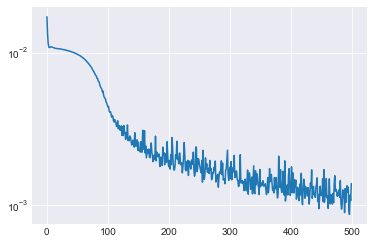

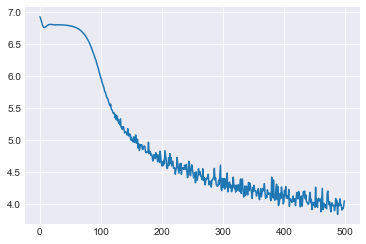

In [48]:
sparse_me_model = maxent_fit(sparse_trajs, restraints)

Plotting 10 patches in a 3 x 4 grid


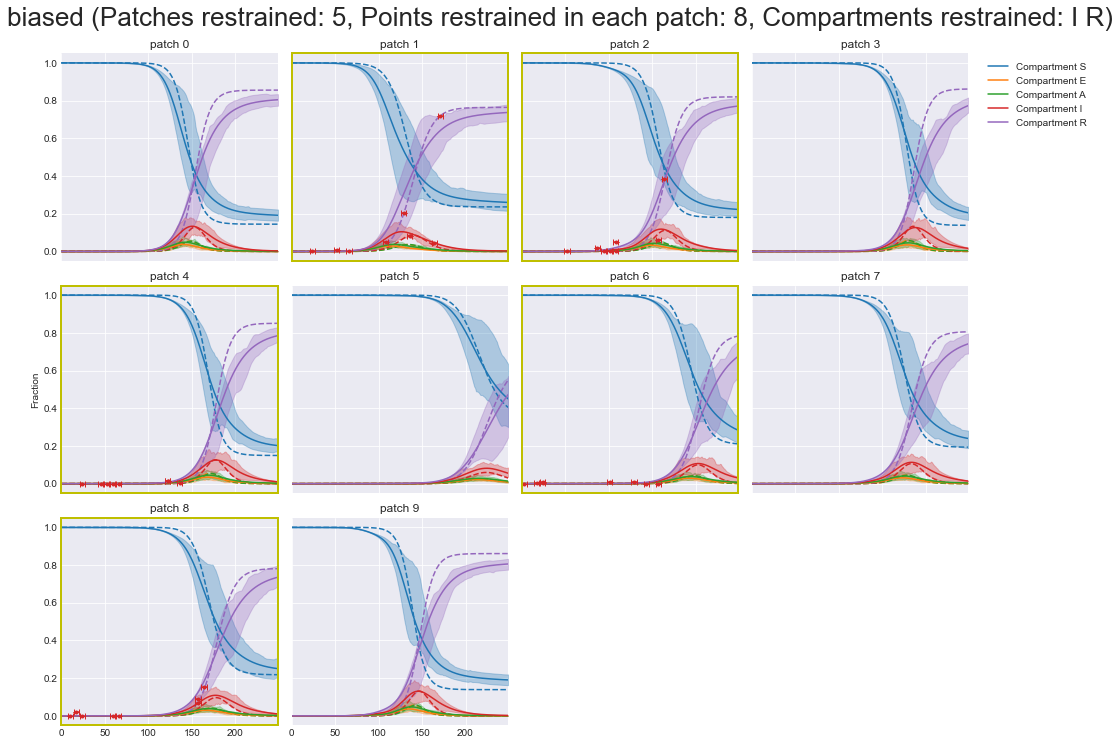

In [49]:
weights_dict = {'unbiased':None, 'biased':sparse_me_model.traj_weights}
compare_patches(sparse_ref_traj, sparse_trajs, weights_dict,'biased', patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

Top 5 posterior probabilities for P0: 
 [(0.7571888636862586, 'patch 1'), (0.06219838383650125, 'patch 2'), (0.06110596124469504, 'patch 9'), (0.02403813617111775, 'patch 0'), (0.019637559426602023, 'patch 7')]


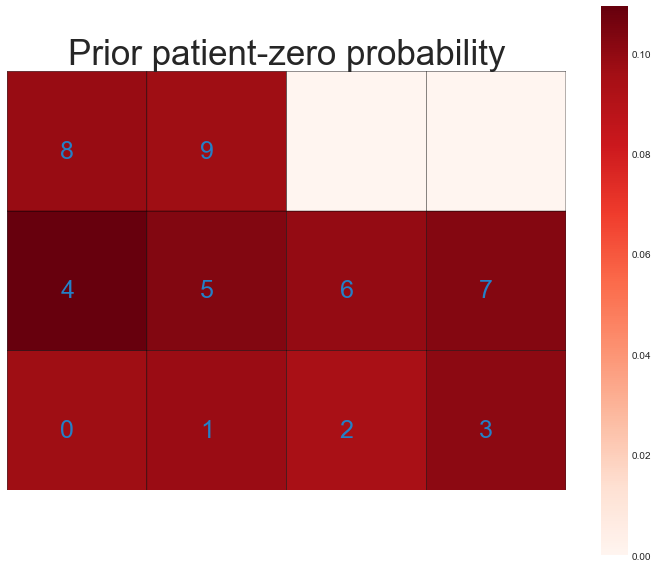

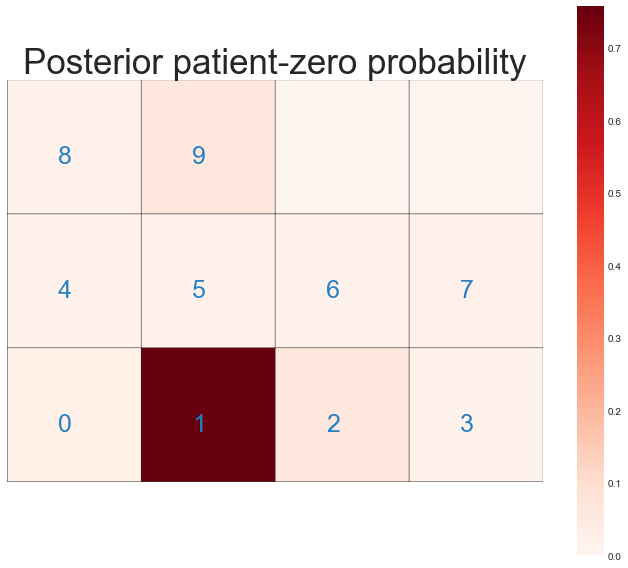

In [50]:
prior_exposed_patch = maxentep.exposed_finder(sparse_trajs)
maxentep.p0_map(prior_exposed_patch, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch, M, weights = sparse_me_model.traj_weights, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = sparse_me_model.traj_weights)
print('Top 5 posterior probabilities for P0: \n', sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5])

# Case 4

3.3

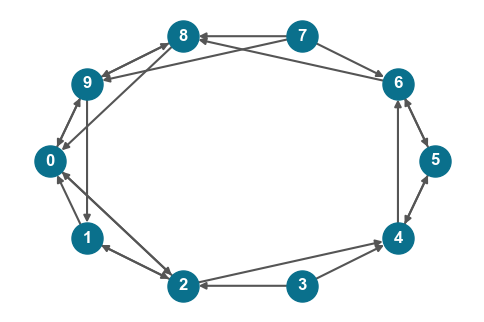

In [52]:
graph, edge_list, node_list = gen_graph(10)
fig, ax = plt.subplots(dpi=100)
graph.remove_edges_from([(1, i) for i in range(3,9)])
graph.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i!=1])
graph.remove_edges_from([(i, 2) for i in range(4,9)])
graph.remove_edges_from([(i, 6) for i in range(0,4)])
graph.remove_edges_from([(i, 7) for i in range(1,10) if i!=7])
graph.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5] )
graph.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph.remove_edges_from([(9,i) for i in range(2,8)])
graph.remove_edges_from([(i,9) for i in range(1,7)])
graph.remove_edges_from([(0, i) for i in range(3,9)])
graph.remove_edges_from([(i, 0) for i in range(3,8)])
graph.remove_edges_from([(i, 8) for i in range(2,6)])
graph.remove_edges_from([(8, i) for i in range(1,8) if i!=7 and i!=8])
graph.remove_edges_from([(i, 4) for i in range(6,9)])
nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)
graph_dof(graph.edges(), node_list)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


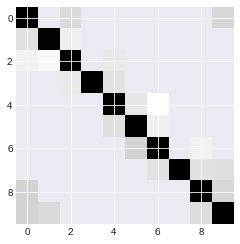

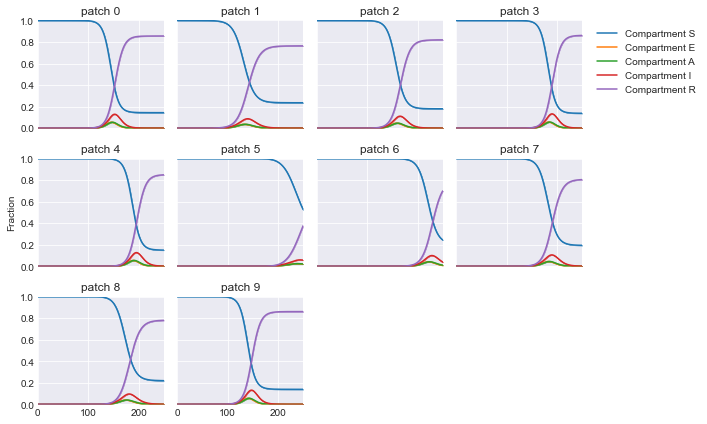

In [55]:
sparse_mobility_matrix = sparse_graph_mobility(graph, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix))
sparse_ref_traj = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population, area=area, mobility_matrix=sparse_mobility_matrix)
patch_quantile(sparse_ref_traj, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])


Restraints are set in this time range: [0, 180]
45 4.9667262e-05 0.019235100589612305
136 0.08495229 0.1064529675702906
3 6.238783e-07 0.0
59 0.00018660694 0.021326364772405754
164 0.6840473 0.6888285878350031
17 5.255461e-06 0.0
59 0.00037452305 0.011789399993455943
157 0.62696403 0.6231989944553926
150 8.005891e-05 0.01761459438521688
24 2.0391783e-13 0.0
80 5.106817e-09 0.0
10 1.4652303e-15 0.01898811047586584
87 1.7820138e-08 0.031755248295045606
38 3.8962336e-12 0.0
101 1.3874296e-07 0.0
80 6.1723315e-09 0.019935199028727847
38 1.9695439e-12 0.018798102627141818
157 6.681636e-05 0.009331399882411244
66 2.3539734e-10 0.0
122 6.707811e-07 0.0
122 9.2272785e-07 0.009156852072497815
59 8.524877e-11 0.0
10 1.1161684e-16 0.0
80 2.3804625e-09 0.00874487985796799
108 0.0039054563 0.04230525138303262
66 1.6818269e-05 0.0
10 2.8317244e-09 0.008657514857543585
38 3.6637218e-07 0.0008324995649211187
129 0.077034175 0.06365411041679095
101 0.0023240733 0.0
17 1.0084436e-08 0.0
157 0.64588124 0

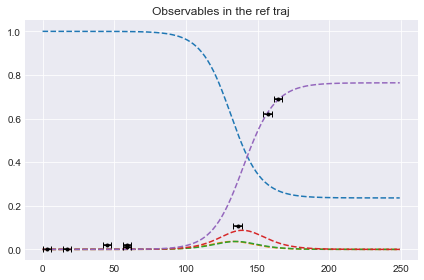

In [56]:
restraints, plot_fxns_list, restrained_patches = gen_restraints(sparse_ref_traj)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.40s/it]


Plotting 10 patches in a 3 x 4 grid


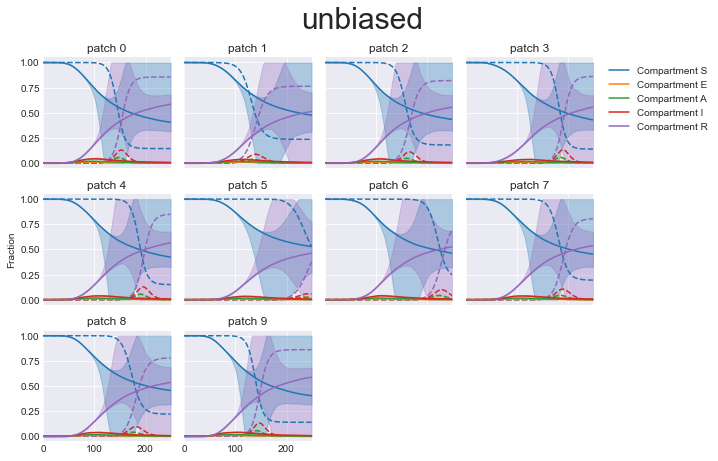

In [57]:
sparse_trajs = gen_samples(sparse_mobility_matrix, timesteps =250, area = area, populations = population, sparse=True)
compare_to_ref(sparse_ref_traj, sparse_trajs, weights=None, method='unbiased', patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0138 - weight-entropy: 6.9290
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 6.9178
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 6.9135
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0130 - weight-entropy: 6.9139
Epoch 5/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0127 - weight-entropy: 6.9138
Epoch 6/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0124 - weight-entropy: 6.9110
Epoch 7/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 6.9047
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0119 - weight-entropy: 6.8963
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0116 - weight-entropy: 6.8865
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 5.4815
Epoch 80/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0026 - weight-entropy: 5.4722
Epoch 81/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0026 - weight-entropy: 5.4670
Epoch 82/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0026 - weight-entropy: 5.4559
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 5.4281
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 5.4259
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 5.4006
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 5.3935
Epoch 87/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 5.3772
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.002

4/4 [==============================] - 0s 2ms/step - loss: 9.5897e-04 - weight-entropy: 4.6558
Epoch 158/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.6688
Epoch 159/500
4/4 [==============================] - 0s 1ms/step - loss: 9.8858e-04 - weight-entropy: 4.6437
Epoch 160/500
4/4 [==============================] - 0s 1ms/step - loss: 9.5216e-04 - weight-entropy: 4.6430
Epoch 161/500
4/4 [==============================] - 0s 1ms/step - loss: 9.0319e-04 - weight-entropy: 4.6155
Epoch 162/500
4/4 [==============================] - 0s 1ms/step - loss: 8.9128e-04 - weight-entropy: 4.6121
Epoch 163/500
4/4 [==============================] - 0s 2ms/step - loss: 9.9572e-04 - weight-entropy: 4.6468
Epoch 164/500
4/4 [==============================] - 0s 2ms/step - loss: 9.6243e-04 - weight-entropy: 4.6155
Epoch 165/500
4/4 [==============================] - 0s 1ms/step - loss: 8.9467e-04 - weight-entropy: 4.5953
Epoch 166/500
4/4 [==================

4/4 [==============================] - 0s 1ms/step - loss: 7.6464e-04 - weight-entropy: 4.2404
Epoch 233/500
4/4 [==============================] - 0s 2ms/step - loss: 6.5366e-04 - weight-entropy: 4.2047
Epoch 234/500
4/4 [==============================] - 0s 2ms/step - loss: 7.5875e-04 - weight-entropy: 4.2809
Epoch 235/500
4/4 [==============================] - 0s 1ms/step - loss: 6.5399e-04 - weight-entropy: 4.2155
Epoch 236/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4334e-04 - weight-entropy: 4.1900
Epoch 237/500
4/4 [==============================] - 0s 1ms/step - loss: 7.9114e-04 - weight-entropy: 4.2622
Epoch 238/500
4/4 [==============================] - 0s 1ms/step - loss: 6.2044e-04 - weight-entropy: 4.1565
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 6.0547e-04 - weight-entropy: 4.1721
Epoch 240/500
4/4 [==============================] - 0s 2ms/step - loss: 6.0756e-04 - weight-entropy: 4.1501
Epoch 241/500
4/4 [==============

4/4 [==============================] - 0s 1ms/step - loss: 6.9433e-04 - weight-entropy: 4.0669
Epoch 308/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2232e-04 - weight-entropy: 3.9734
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2332e-04 - weight-entropy: 4.0137
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 5.4126e-04 - weight-entropy: 3.9596
Epoch 311/500
4/4 [==============================] - 0s 1ms/step - loss: 5.1922e-04 - weight-entropy: 3.9734
Epoch 312/500
4/4 [==============================] - 0s 2ms/step - loss: 4.9865e-04 - weight-entropy: 3.9346
Epoch 313/500
4/4 [==============================] - 0s 1ms/step - loss: 5.0479e-04 - weight-entropy: 3.9612
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 4.5961e-04 - weight-entropy: 3.9285
Epoch 315/500
4/4 [==============================] - 0s 1ms/step - loss: 5.9590e-04 - weight-entropy: 3.9833
Epoch 316/500
4/4 [==============

4/4 [==============================] - 0s 1ms/step - loss: 6.4726e-04 - weight-entropy: 3.9486
Epoch 383/500
4/4 [==============================] - 0s 1ms/step - loss: 5.9018e-04 - weight-entropy: 3.8991
Epoch 384/500
4/4 [==============================] - 0s 1ms/step - loss: 5.5170e-04 - weight-entropy: 3.7973
Epoch 385/500
4/4 [==============================] - 0s 1ms/step - loss: 6.0981e-04 - weight-entropy: 3.8926
Epoch 386/500
4/4 [==============================] - 0s 2ms/step - loss: 7.2689e-04 - weight-entropy: 3.9838
Epoch 387/500
4/4 [==============================] - 0s 1ms/step - loss: 4.6861e-04 - weight-entropy: 3.7762
Epoch 388/500
4/4 [==============================] - 0s 1ms/step - loss: 5.7986e-04 - weight-entropy: 3.8551
Epoch 389/500
4/4 [==============================] - 0s 2ms/step - loss: 5.7831e-04 - weight-entropy: 3.8327
Epoch 390/500
4/4 [==============================] - 0s 2ms/step - loss: 5.3850e-04 - weight-entropy: 3.7833
Epoch 391/500
4/4 [==============

4/4 [==============================] - 0s 2ms/step - loss: 4.6235e-04 - weight-entropy: 3.7540
Epoch 458/500
4/4 [==============================] - 0s 1ms/step - loss: 6.5701e-04 - weight-entropy: 3.8865
Epoch 459/500
4/4 [==============================] - 0s 1ms/step - loss: 4.2607e-04 - weight-entropy: 3.7280
Epoch 460/500
4/4 [==============================] - 0s 2ms/step - loss: 5.5457e-04 - weight-entropy: 3.7897
Epoch 461/500
4/4 [==============================] - 0s 1ms/step - loss: 6.2858e-04 - weight-entropy: 3.9018
Epoch 462/500
4/4 [==============================] - 0s 2ms/step - loss: 4.7502e-04 - weight-entropy: 3.7177
Epoch 463/500
4/4 [==============================] - 0s 2ms/step - loss: 4.7262e-04 - weight-entropy: 3.7564
Epoch 464/500
4/4 [==============================] - 0s 1ms/step - loss: 6.4528e-04 - weight-entropy: 3.8432
Epoch 465/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4517e-04 - weight-entropy: 3.8691
Epoch 466/500
4/4 [==============

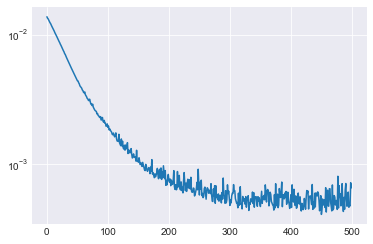

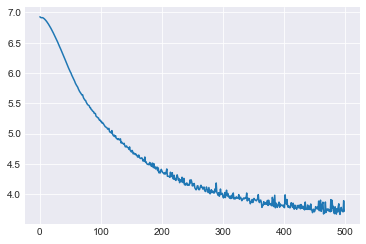

In [58]:
sparse_me_model = maxent_fit(sparse_trajs, restraints)

Plotting 10 patches in a 3 x 4 grid


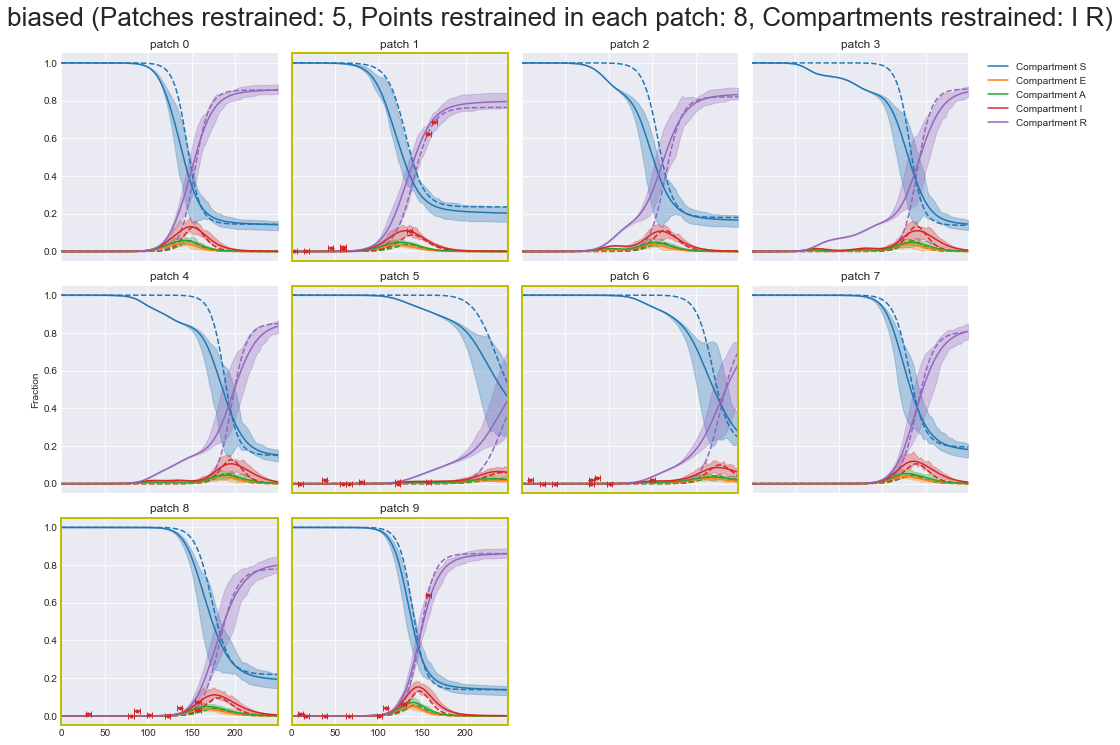

In [59]:
weights_dict = {'unbiased':None, 'biased':sparse_me_model.traj_weights}
compare_patches(sparse_ref_traj, sparse_trajs, weights_dict,'biased', patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

Top 5 posterior probabilities for P0: 
 [(0.7564225680625795, 'patch 1'), (0.09746641612883583, 'patch 2'), (0.08239104838214173, 'patch 3'), (0.012400723993064359, 'patch 4'), (0.010836450843844, 'patch 0')]


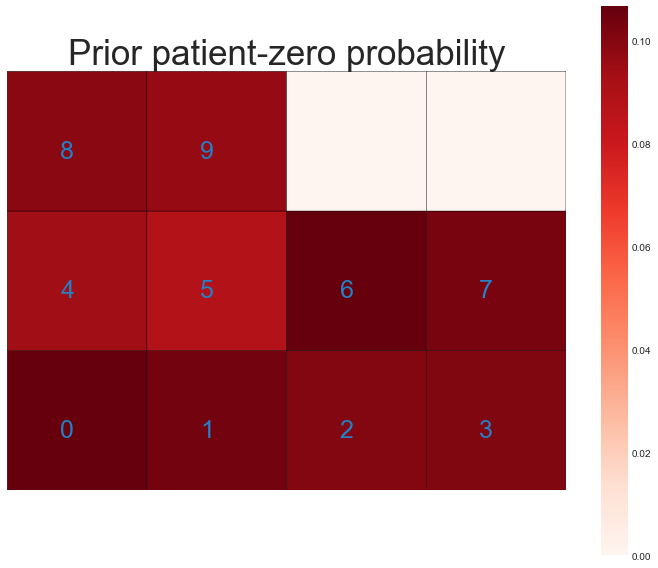

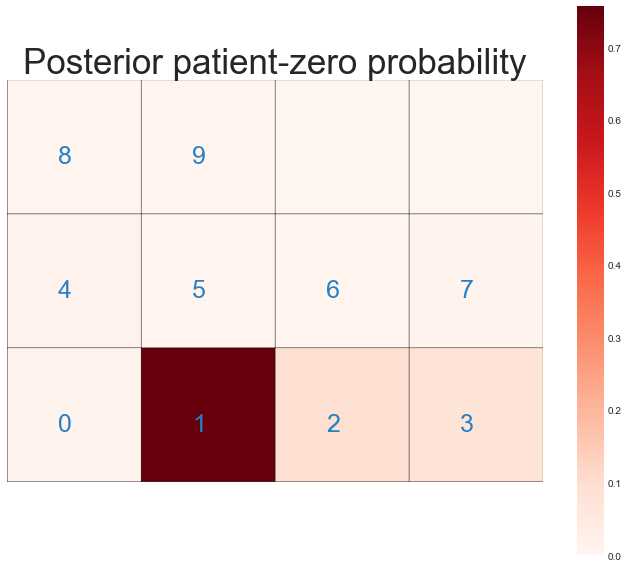

In [60]:
prior_exposed_patch = maxentep.exposed_finder(sparse_trajs)
maxentep.p0_map(prior_exposed_patch, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch, M, weights = sparse_me_model.traj_weights, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = sparse_me_model.traj_weights)
print('Top 5 posterior probabilities for P0: \n', sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5])